# FOMC Topic Modeling

_Our discussions of the economy may sometimes ring in the ears of the public with more certainty than is appropriate_ - Jerome Powell 

The Federal Open Market Committee (FOMC) meeting minutes may reveal the Federal Reserve's economic outlook, policy decisions, and potential future actions. Analyzing these minutes can help identify key topics discussed over time, shedding light on trends in monetary policy and their implications for financial markets. We review methods for accessing and pre-processing textual data, including the use MongoDB for storing and retrieving unstructured data.  Several topic modeling algorithms, including Latent Semantic Analysis (LSA), Latent Dirichlet Allocation (LDA), Non-negative Matrix Factorization (NMF), and Probabilistic Latent Semantic Indexing (PLSI), are applied to uncover patterns within the minutes.



In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
import sklearn.feature_extraction, sklearn.decomposition
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from scipy.special import softmax
from wordcloud import WordCloud
import wordcloud
import matplotlib.pyplot as plt
from finds.database import MongoDB
from finds.unstructured import Unstructured
from finds.utils import Store
from finds.readers import FOMCReader, Alfred
from pprint import pprint
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [3]:
## retrieve recessions dates for plotting
alf = Alfred(api_key=credentials['fred']['api_key'])
vspans = alf.date_spans(series_id='USREC')

## FOMC meeting minutes

The FOMC holds eight scheduled meetings per year, with additional meetings as necessary. The minutes from these meetings are released three weeks after the policy decision, offering crucial insights into the Federal Reserve's economic stance and possible future monetary policy actions. These insights can influence interest rates, inflation expectations, and overall market conditions.

For official meeting schedules and minutes, visit: [Federal Reserve FOMC Calendar](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm).

### FinDS `fomcreader` module

The `fomcreader` module in the FinDS packages offers functions for searching and retrieving meeting minutes from the Federal Reserve website.




In [4]:
# Helper class to scrape FOMC meeting minutes from Federal Reserve website
minutes = FOMCReader()

# Show number and date range of minutes available from website
DataFrame({'dates': len(minutes), 'start': min(minutes), 'end': max(minutes)},
          index=['FOMC minutes'])

100%|██████████| 27/27 [00:16<00:00,  1.66it/s]


,dates,start,end
FOMC minutes,256,19930203,20250129


### MongoDB

MongoDB is a NoSQL ("not only SQL") document-oriented database designed to efficiently manage unstructured and semi-structured data. Unlike traditional relational databases, MongoDB does not enforce a fixed schema, allowing for greater flexibility in handling diverse data formats. Each document (record) within a collection (table equivalent) can contain different fields and structures, including key-value pairs, arrays, and embedded subdocuments.


In [10]:
# store unstructured minutes text data in MongoDB 
from pprint import pprint
mongodb = MongoDB(**credentials['mongodb'], verbose=VERBOSE)
print('uptime:', mongodb.client.admin.command("serverStatus")['uptime'])
fomc = Unstructured(mongodb, 'FOMC')

177.0


In [11]:
# retrieve keys (dates) of minutes previously retrieved and stored locally
dates = fomc['minutes'].distinct('date')

In [15]:
# fetch new minutes from FOMC site
docs = {d: minutes[d] for d in minutes if d not in dates}
print("New minutes:")
pprint([f"{k}: {len(v)} chars" for k,v in docs.items()])

New minutes:
['20250129: 54324 chars',
 '20240612: 43860 chars',
 '20240731: 44839 chars',
 '20240918: 44372 chars',
 '20241107: 49178 chars',
 '20241218: 45712 chars']


__Preprocessing Meeting Minutes__

1. Extract relevant sections of the minutes, starting from:
   - "Review of Monetary Policy Strategy, Tools, and Communications"
   - "Developments in Financial Markets"
   - "Discussion of Guidelines for Policy Normalization"
   - "Financial Developments and Open Market Operations"
   - "Discussion of the Economic Outlook"
   - "The information reviewed at this meeting"
   - "The staff presented several briefings"
   
2. Remove text following the adjournment line or the date scheduled for the next meeting. Exclude:
   - Notation votes, approvals of minutes, signatures, and footnotes
   - Intermeeting conference call discussions

Once extracted, store and retrieve all meeting minutes from MongoDB for further processing.

In [7]:
# Helper function to trim minutes text
def edit(text: str) -> str:
    """helper to spawn editor and write/edit/read to tempfile"""
    import subprocess
    import tempfile
    with tempfile.NamedTemporaryFile(suffix=".tmp") as f: # save temp file
        f.write(text.encode("utf-8"))
        f.flush()
        subprocess.call([os.environ.get('EDITOR','emacs'), "-nw", f.name])
        f.seek(0)
        return f.read().decode("utf-8")        # keep edited text

In [8]:
if docs:
    # to edit out head and tail of each document
    results = list()   
    for date, initial_message in docs.items():   
        edited_text = edit(initial_message)
        results.append({'date': date, 'text' : edited_text})
    results = sorted(results, key = lambda x: x['date'])   # sort by date

    # save edited docs
    Store(paths['scratch'] / 'fomc', ext='gz').dump(results, f"{max(docs.keys())}.json")
    for doc in results: # store docs for new dates
        fomc.insert('minutes', doc, keys=['date'])

Retrieve all minutes that were stored locally in MongoDB

In [16]:
docs = Series({doc['date']: doc['text'] for doc in fomc.select('minutes')},
              name='minutes').sort_index()
DataFrame(docs)

,minutes
19930203,The Manager of the System Open Market Account ...
19930323,The Deputy Manager for Domestic Operations rep...
19930518,The Manager of the System Open Market Account ...
19930707,The Deputy Manager for Domestic Operations rep...
19930817,The Deputy Manager for Domestic Operations rep...
...,...
20240731,Developments in Financial Markets and Open Mar...
20240918,Developments in Financial Markets and Open Mar...
20241107,Developments in Financial Markets and Open Mar...
20241218,Developments in Financial Markets and Open Mar...


## Text pre-processing
Text preprocessing involves cleaning and preparing raw text data by removing noise, standardizing formats, and converting text into a structured form suitable for analysis. This process typically includes tokenization, removing stop words, and vectorizing the text.

### Tokenization

Tokenization splits text into smaller units called **tokens**, typically words, though they may also be phrases or subwords. The pattern of tokenization is often defined using regular expressions.

The original **casing** of words may be preserved if it carries meaningful information, such as distinguishing proper nouns, acronyms, or sentence boundaries. Some models may interpret all uppercase words as organizations.




### Regular expressions

Regular expressions (**regex**) define search patterns for text processing, often used in tokenization to find word boundaries and remove unwanted characters.

**Basic Regular Expressions**


| Expression | Description |
|------------|-------------|
| `\d` | Matches a digit (0-9) |
| `\w` | Matches a word character (ASCII letter, digit, or underscore) |
| `\s` | Matches a whitespace character (space, tab, newline) |
| `\D` | Matches a non-digit character |
| `\W` | Matches a non-word character |
| `\S` | Matches a non-whitespace character |
| `[ ... ]` | Matches one of the characters in the brackets |
| `[a-zA-Z]` | Matches any letter (uppercase or lowercase) |
| `[^a]` | Matches any character except `a` |
| `\b` | Matches a word boundary |
| `.` | Matches any character except a line break |
| `\.` | Matches a period character |
| `^` | Matches the start of a string |
| `$` | Matches the end of a string |
| `+` | Matches one or more occurrences |
| `*` | Matches zero or more occurrences |
| `?` | Matches zero or one occurrence |
| `\|` | Acts as an OR operator |
| `( ... )` | Defines a capturing group |

### Stopwords

Common, uninformative words (e.g., "the," "is," "and") can be removed to focus on meaningful content in the analysis.  Corpus-specific uninformative words (such as calendar-related terms in FOMC minutes) can also be excluded.



In [17]:
# ignore these stop words
StopWords = [w for w in set(wordcloud.STOPWORDS) if "'" not in w]
StopWords += ['january', 'february', 'march', 'april', 'may', 'june',
              'july', 'august', 'september', 'october', 'november',
              'december', 'first', 'second', 'third', 'fourth', 'twelve',
              'participants', 'members', 'meeting']

### Vectorization

Vectorization transforms text into numerical representations suitable for analysis.

- **Bag-of-Words (BoW):** Represents a document by the frequency of its words, ignoring grammar and word order.
- **N-grams:** Treats consecutive words as distinct items rather than isolated words.
- Indexing: Assigns unique integer indexes to words in the corpus.
- **TF-IDF (Term Frequency-Inverse Document Frequency):** Measures word importance based on its frequency in a document relative to its occurrence across all documents.
  - The `scikit-learn` package provides `TfidfVectorizer` for TF-IDF vectorization and `CountVectorizer` for raw word counts.




In [18]:
# To vectorize the input words
#ngram_range = (1, 1)   # unigrams
#ngram_range = (2, 2)   # bigrams
ngram_range = (1, 2)   # unigrams and bigrams
max_df, min_df, max_features = 0.5, 6, 5000 # some reasonable constraints
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b") #r'\b[^\d\W]+\b'
tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,        # (2, 2) for bigrams
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")

## Topic Modeling

Topic modeling applies statistical techniques to discover latent topics within a collection of documents.

### Latent Semantic Analysis (LSA)

**LSA** uses singular value decomposition (SVD) to analyze relationships between terms and documents. By reducing dimensionality, it groups terms and documents that frequently co-occur in a lower-dimensional space, revealing underlying topics.

### Latent Dirichlet Allocation (LDA)

**LDA** assumes each document is a mixture of topics, and each topic is a mixture of words. It iteratively assigns words to topics based on probability distributions, refining topic assignments over multiple iterations.

### Non-negative Matrix Factorization (NMF)

**NMF** decomposes a term-document matrix into two non-negative matrices:
- A basis matrix representing topics
- A coefficient matrix representing the distribution of topics in documents

By optimizing these matrices, NMF extracts meaningful topics from the text.

### Probabilistic Latent Semantic Indexing (PLSI)

**PLSI** models documents as mixtures of topics, estimating probability distributions of words and topics iteratively until convergence. It can be implemented using NMF with generalized Kullback-Leibler divergence as the loss function.

- [scikit-learn decomposition documentation](https://scikit-learn.org/stable/modules/decomposition.html#nmf)
- [Example of topic extraction with NMF & LDA](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)

In [19]:
# Define models
n_components = 4   # fix number of latent topics
algos = {
    'LSA': (TruncatedSVD(n_components=n_components),
            tfidf_vectorizer),
    'LDA': (LatentDirichletAllocation(n_components=n_components,
                                      learning_method='batch', #'online',
                                      # learning_offset = 50.0,
                                      max_iter = 40,
                                      random_state = 42),
            tf_vectorizer),
    'PLSI': (NMF(n_components=n_components,
                 beta_loss='kullback-leibler',
                 solver='mu', 
                 alpha_W=0.00005,
                 alpha_H=0.00005,
                 l1_ratio=0.5,
                 max_iter=1000,
                 random_state = 42),
             tfidf_vectorizer),
    'NMF': (NMF(n_components=n_components,
                random_state=42,
                beta_loss='frobenius',
                alpha_W=0.00005,
                alpha_H=0.00005,
                l1_ratio=0.5),
            tfidf_vectorizer)}

Once topics are extracted, they can be visualized over time to observe trends in FOMC discussions.

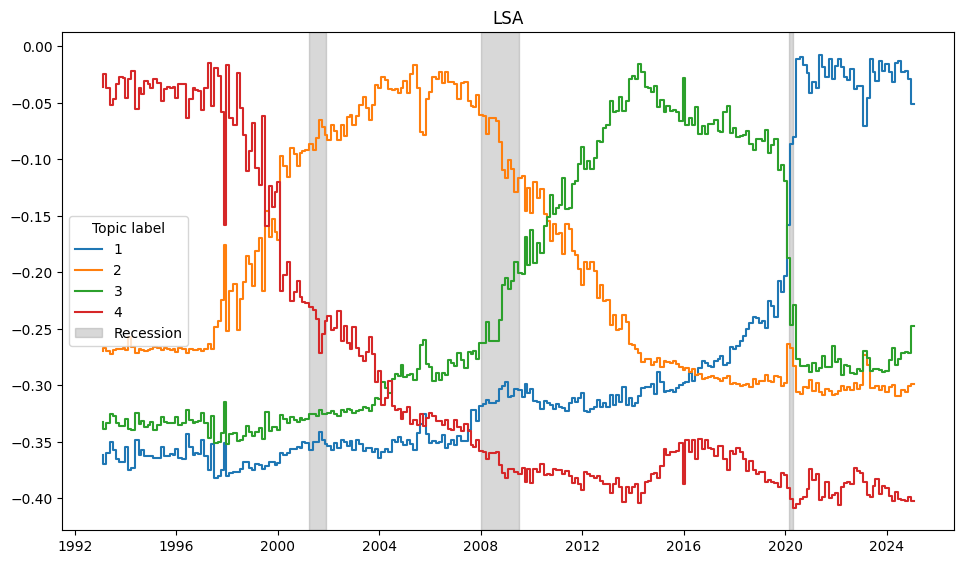

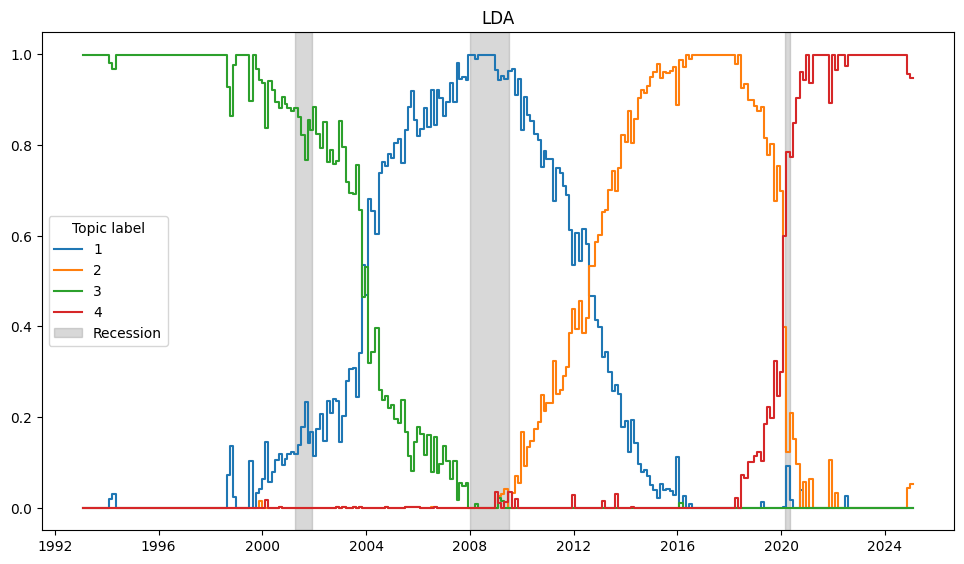

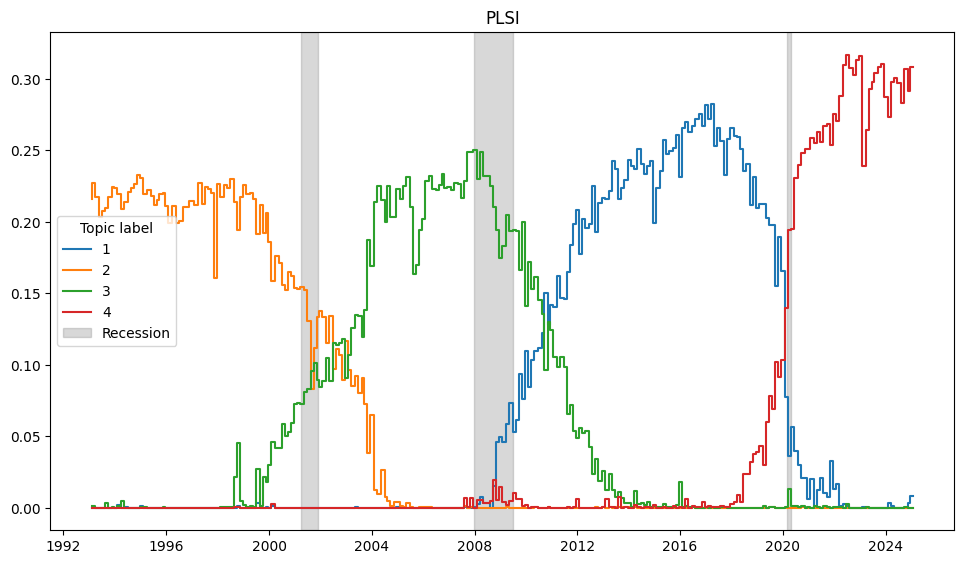

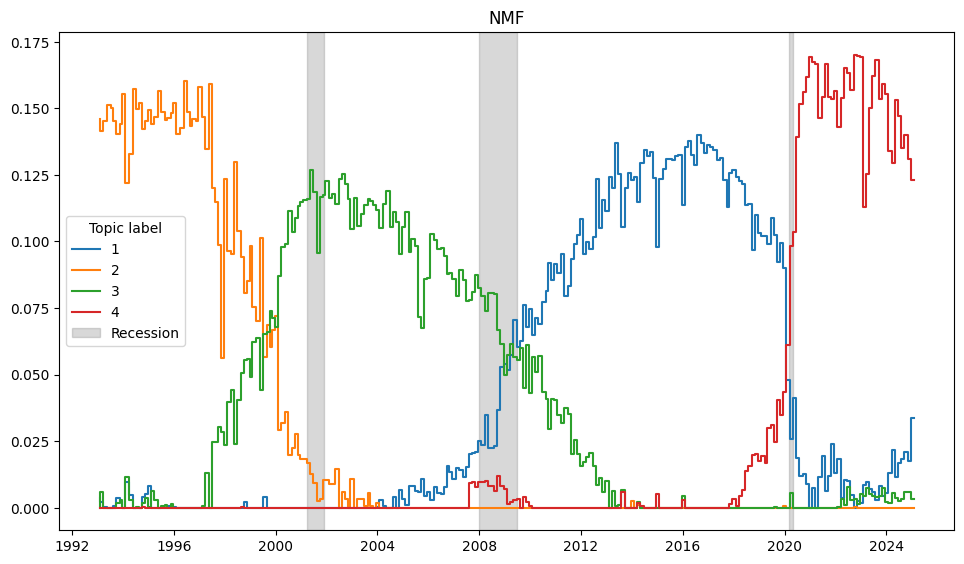

In [22]:
# Fit and plot models
scores = dict()   # to save model coefficients
topics = dict()   # to save dates of primary topic
for ifig, (name, (base, vectorizer)) in enumerate(algos.items()):

    # vectorize the input words
    vectorized = vectorizer.fit_transform(docs.to_list())
    feature_names = vectorizer.get_feature_names_out()

    # fit model and transform inputs
    model = base.fit(vectorized)
    transformed = model.transform(vectorized)

    # save the model fitted coefficients
    if name == 'LSA':  # Additional step for LSA
        kmeans = KMeans(n_clusters=n_components, n_init=5, random_state=37)\
            .fit(transformed)    # find centroids of the latent factors
        transformed = kmeans.transform(transformed)  # distance to centroid
        transformed = -(transformed / transformed.sum(axis=1, keepdims=True))
        scores[name] = softmax(model.components_, axis=1)  # scale word scores
    else:
        scores[name] = model.components_

    # plot topic scores over time
    fig, ax = plt.subplots(num=1 + ifig, clear=True, figsize=(10, 6))
    dates = pd.DatetimeIndex(docs.index.astype(str))        
    ax.step(dates, transformed, where='pre')
    for a,b in vspans:
        if b >= min(dates):
            ax.axvspan(a, min(b, max(dates)), alpha=0.3, color='grey')
    ax.set_title(name)
    ax.legend([f"{i+1}" for i in range(n_components)] + ['Recession'],
              loc='center left', title='Topic label')
    plt.tight_layout(pad=2)

    # save dates of primary topic
    for topic in range(transformed.shape[1]):
        arg = DataFrame({'t': np.argmax(transformed, axis=1),
                         'dt': docs.index})
        dates = (arg!=arg.shift()).cumsum().groupby('t').agg(['first', 'last']) - 1
        dates['topic'] = arg.loc[dates.iloc[:,1], 't'].values
        topics[name] = {topic: [(arg['dt'].iloc[row[0]], arg['dt'].iloc[row[1]])
                                for row in dates.itertuples(index=False, name=None)
                                if row[2] == topic]
                        for topic in range(transformed.shape[1])}

### Feature importance

The most significant words for each topic are identified and visualized using the `WordCloud` package, providing an intuitive representation of key themes.

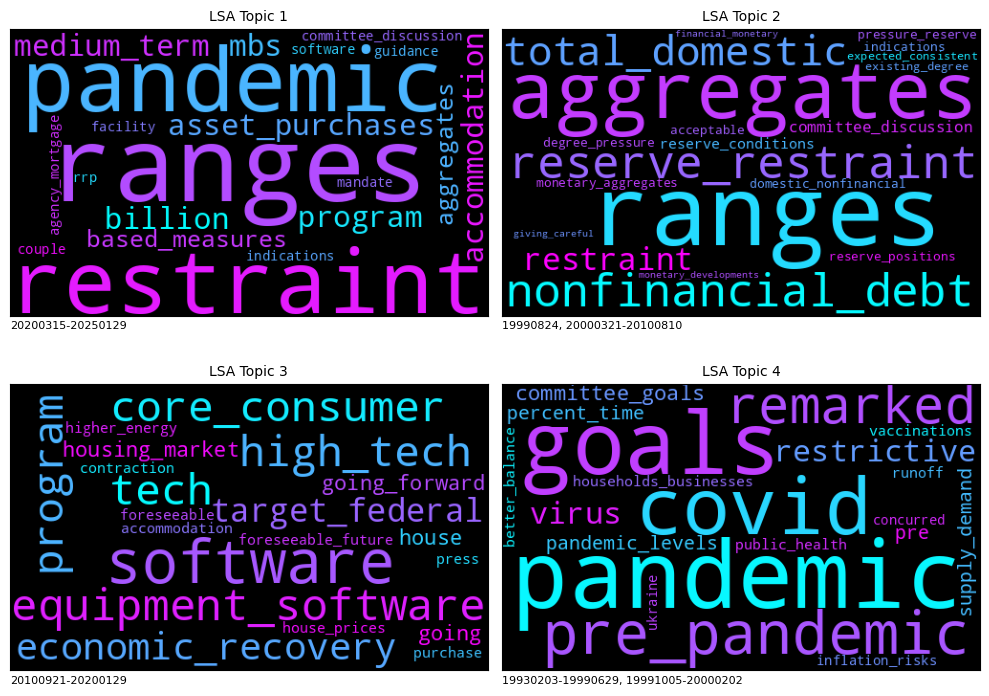

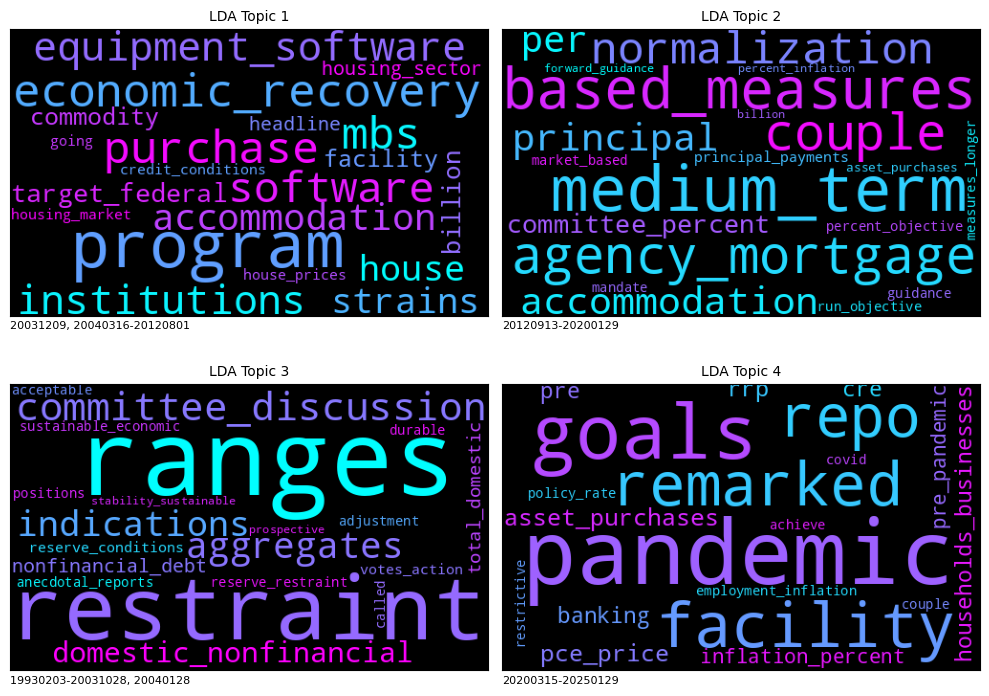

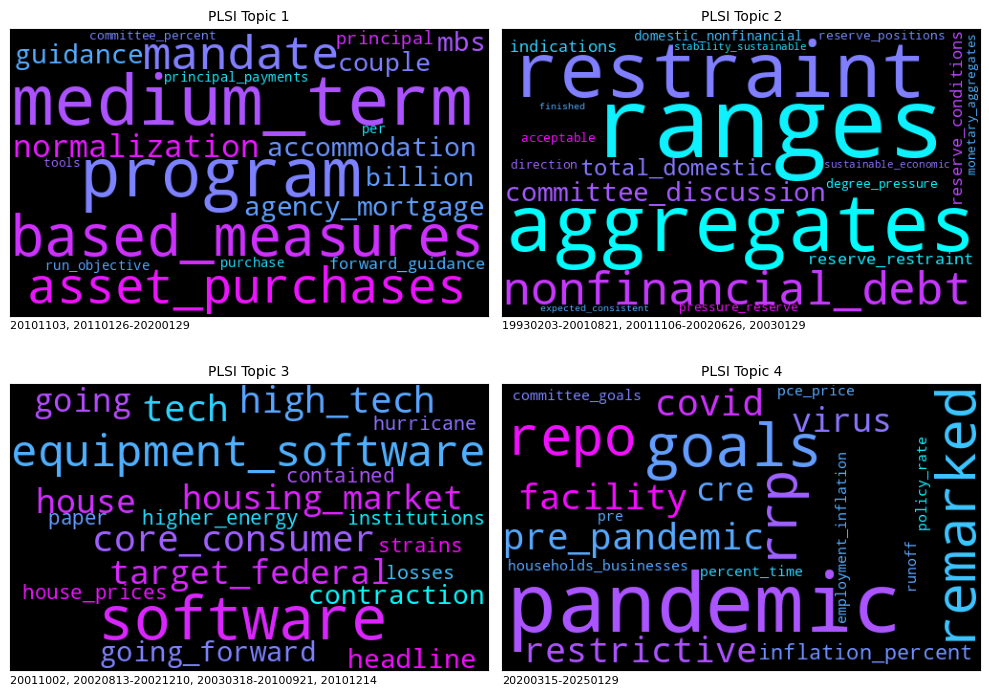

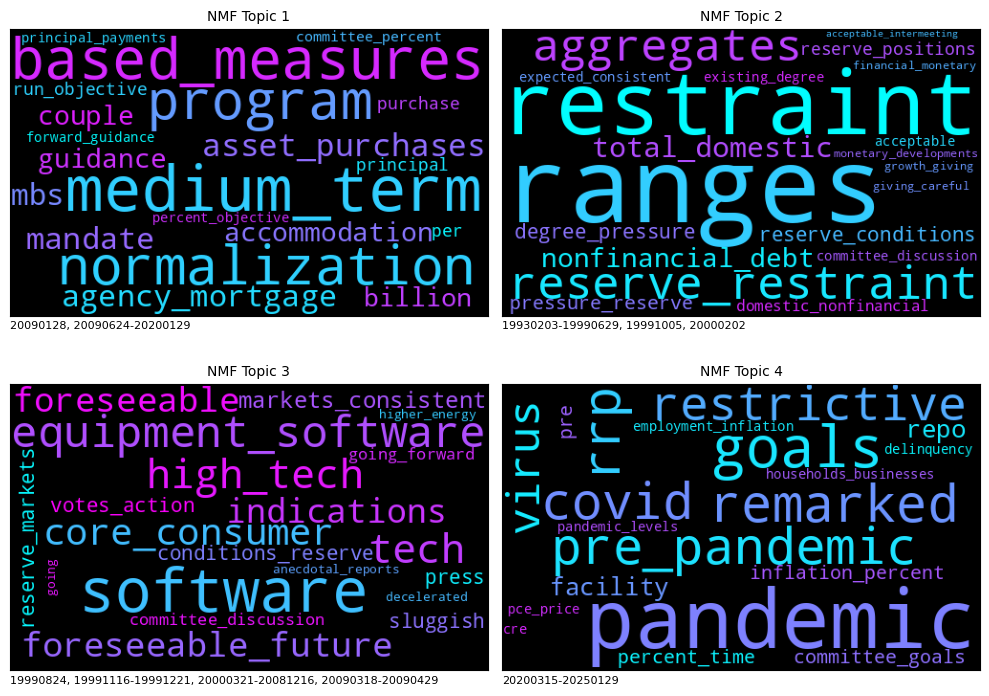

In [23]:
# Display word cloud of top n features, by model and topic
figsize = (10, 8)
for ifig, (name, score) in enumerate(scores.items()):
    wc = WordCloud(height=300, width=500, colormap='cool') 
    top_n = 20
    fig, axes = plt.subplots(2, 2, num=ifig+5, figsize=figsize, clear=True)
    for topic, components in enumerate(score):
        words = {feature_names[i].replace(' ','_') : components[i]
                 for i in components.argsort()[:-top_n - 1:-1]}
        #print("Topic", topic+1, topics[name])
        #print(list(words.keys()))
        ax = axes[topic//2, topic % 2]
        ax.imshow(wc.generate_from_frequencies(words))
        ax.axes.yaxis.set_visible(False)   # make axes ticks invisible
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.set_title(f"{name} Topic {topic+1}", fontsize=10)
        regime = ", ".join([f"{d[0]}-{d[1]}" if d[0] != d[1] else f"{d[0]}"
                            for d in topics[name][topic]])            
        ax.set_xlabel(regime if len(regime) < 75 else '-- many --',
                      fontsize=8,
                      loc='left')
        plt.tight_layout()